In [1]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt

In [2]:
#The Defines
BONE_PATH = 'images/bone.jpg'
BORDER_TYPE = cv2.BORDER_CONSTANT
FILTER_SIZE = 7
KERNEL = np.ones((FILTER_SIZE, FILTER_SIZE)) / 49
FRAME_SIZE = 50

In [3]:
## Functions

def avg_filter(dst_img, KERNEL, FILTER_SIZE): # This function will be convolving a FILTER_SIZE * FILTER_SIZE filter with the image
    avg_img = np.zeros((dst_img.shape[0] - FILTER_SIZE + 1, dst_img.shape[1] - FILTER_SIZE + 1))
    for i in range(dst_img.shape[0] - FILTER_SIZE + 1):
        for j in range(dst_img.shape[1] - FILTER_SIZE + 1):
            avg_img[i,j] = np.sum((KERNEL * dst_img[i:i + FILTER_SIZE, j:j + FILTER_SIZE]))
    return avg_img

def create_mask(D0, src): # This function will be making the mask that we want just by passing the D0 parameter
    mask = np.zeros_like(src, float)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i, j] = (np.exp(-1 * ((i - int(src.shape[0]/2 + 1)) * (i - int(src.shape[0]/2 + 1)) + (j - int(src.shape[1]/2 + 1)) * (j - int(src.shape[1]/2 + 1))) / (2 * D0 * D0))) / (2 * np.pi * D0 * D0)
    return mask

In [4]:
# We read the image that we want
Bean_img = cv2.imread(BONE_PATH, 0) 

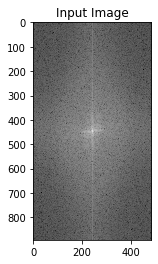

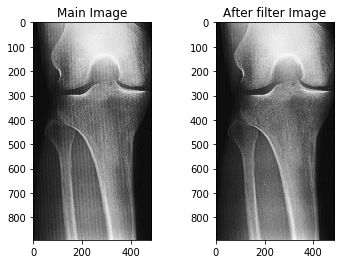

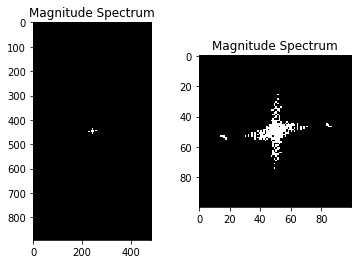

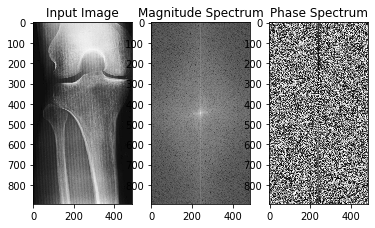

In [5]:
# We calculate the DFT of the image
DFT = np.fft.fft2(Bean_img)
DFT = np.fft.fftshift(DFT)

plt.imshow(np.log(np.abs(DFT)), cmap = 'gray')
plt.title('Input Image')
plt.show()
im_back_B = np.copy(DFT)
# We need to measure the pixel value
im_back_B[np.abs(DFT) > 200000] = 2 * np.max(im_back_B)

plt.subplot(121),plt.imshow(Bean_img, cmap = 'gray')
plt.title('Main Image')


Temp = np.copy(im_back_B)
y_center, x_center = int(Temp.shape[0] / 2), int(Temp.shape[1] / 2)

# In this part we are filtering the bright spots in the frequency domain of the image so it will eliminate the noise
DFT[y_center-5:y_center, x_center+32:x_center+37] = 0.001
DFT[y_center+2:y_center+7, x_center-36:x_center-31] = 0.001

im_back_G = np.fft.ifftshift(DFT)
im_back_G = (np.abs(np.fft.ifft2(im_back_G))).round()
plt.subplot(122),plt.imshow(im_back_G, cmap = 'gray')
plt.title('After filter Image')
plt.show()


# This part will zoom over the image
sub_img = np.copy(Temp[int(Temp.shape[0]/2)-FRAME_SIZE:int(Temp.shape[0]/2) + FRAME_SIZE, int(Temp.shape[1]/2) - FRAME_SIZE:int(Temp.shape[1]/2) + FRAME_SIZE])

# This part well plot the image so we can see it
plt.subplot(121),plt.imshow(np.abs(im_back_B), cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.subplot(122),plt.imshow(np.abs(sub_img), cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()


# This will show the magnitude and phase of the image
DFT = cv2.dft(np.float32(Bean_img),flags = cv2.DFT_COMPLEX_OUTPUT)
DFT_shift = np.fft.fftshift(DFT)
Mag, Phase = cv2.cartToPolar(DFT_shift[:,:,0], DFT_shift[:,:,1], angleInDegrees=0)
plt.subplot(131),plt.imshow(Bean_img, cmap = 'gray')
plt.title('Input Image')
plt.subplot(132), plt.imshow(20 * np.log(Mag), cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.subplot(133), plt.imshow(Phase, cmap = 'gray')
plt.title('Phase Spectrum')
plt.show()

In [6]:
# in order to convolve with the image we need to zero pad the image to have a big view over the iamge
src = Bean_img
top = (FILTER_SIZE - 1) 
bottom = top
left = (FILTER_SIZE - 1)
right = left
dst_img = cv2.copyMakeBorder(Bean_img, top, bottom, left, right, BORDER_TYPE, None, 0)

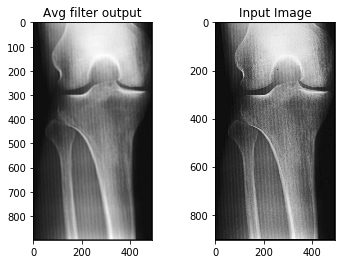

In [7]:
# This part we apply the averqage filter over the image
avg_img = avg_filter(dst_img, KERNEL, FILTER_SIZE)
plt.subplot(121),plt.imshow(avg_img, cmap = 'gray')
plt.title('Avg filter output')
plt.subplot(122),plt.imshow(dst_img, cmap = 'gray')
plt.title('Input Image')
plt.show()

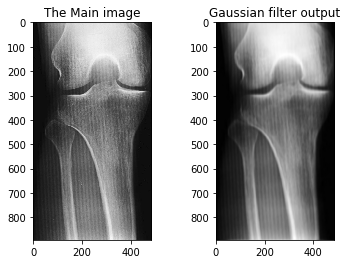

In [8]:
# This part we are using the mask that we wrote the function of it before
mask = create_mask(35, src)
after_filter = (mask * Mag)
rows, cols = src.shape
New_DFT_C = np.zeros((rows,cols,2),np.float32)
New_DFT_C[:,:,0] = after_filter * np.cos(Phase)
New_DFT_C[:,:,1] = after_filter * np.sin(Phase)
f_ishift = np.fft.ifftshift(New_DFT_C)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
# In the end we are going to plot the image of what we have emplemeneted
plt.subplot(121),plt.imshow(src, cmap = 'gray')
plt.title('The Main image')
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Gaussian filter output')
plt.show()